In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [2]:
!wget https://raw.githubusercontent.com/ICascha/QuantGANs-replication/main/backend/gaussianize.py

--2023-12-17 23:15:50--  https://raw.githubusercontent.com/ICascha/QuantGANs-replication/main/backend/gaussianize.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12549 (12K) [text/plain]
Saving to: ‘gaussianize.py’

gaussianize.py      100%[===================>]  12.25K  --.-KB/s    in 0s      

2023-12-17 23:15:50 (26.5 MB/s) - ‘gaussianize.py’ saved [12549/12549]



In [3]:
import yfinance as yf

# Ticker symbol for S&P 500 is "^GSPC" on Yahoo Finance
ticker_symbol = "^GSPC"

start_date = "2009-05-01"
end_date = "2023-10-31"

# Download historical data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Extract and return the 'Close' column
close_data = data['Close']

[*********************100%%**********************]  1 of 1 completed


In [4]:
data.to_csv(f'./SP500_yahoo.csv')

In [5]:
import os, sys

file_name = 'SP500_yahoo'
colab = 'COLAB_GPU' in os.environ
file_path = f'./{file_name}.csv'

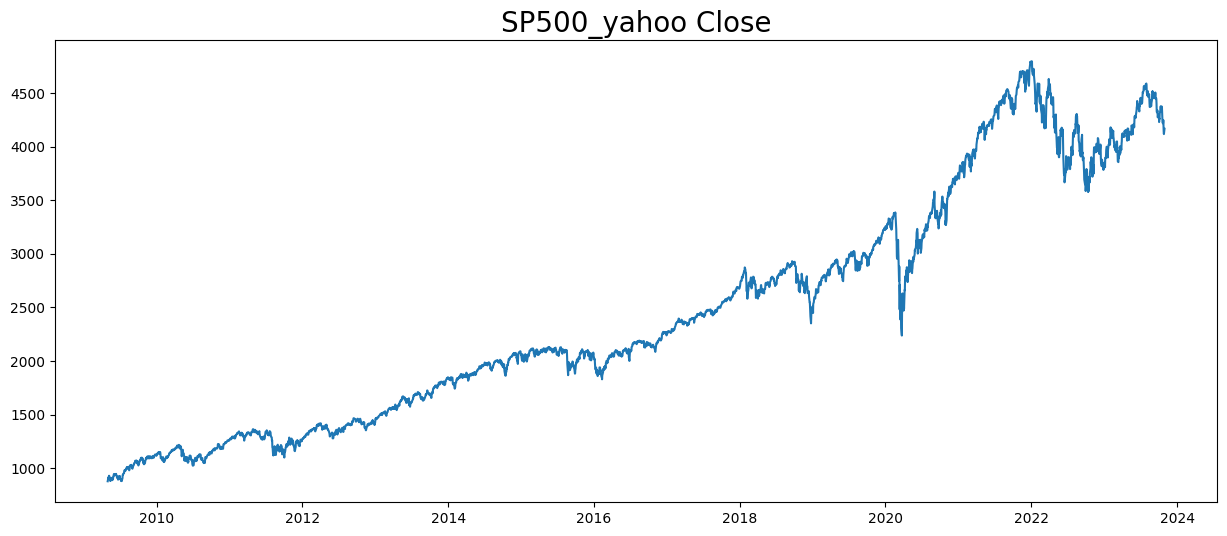

In [6]:
def dateparse(d):
    return pd.Timestamp(d)

data = pd.read_csv(file_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)
df = data['Close']
fig = plt.figure(figsize=(10,5))
plt.title(f'{file_name} Close', fontsize=10)
plt.plot(data['datetime'], data['Close'] )
plt.show()

In finance, the charecteristic of a stock is generally modelled using its return over a certain period (as e.g. a day, a month or a year). It is convention to take the log returns of the security as its expected to have nice properties which can be modelled  $R_t = (S_t - S_{t−1})/S_{t−1} \quad or \quad R_t = log(S_t) - log(S_{t−1})$

In [7]:
returns = df.shift(1)/df - 1
returns.dropna(inplace = True)

In [8]:
from statsmodels.tsa.stattools import acf

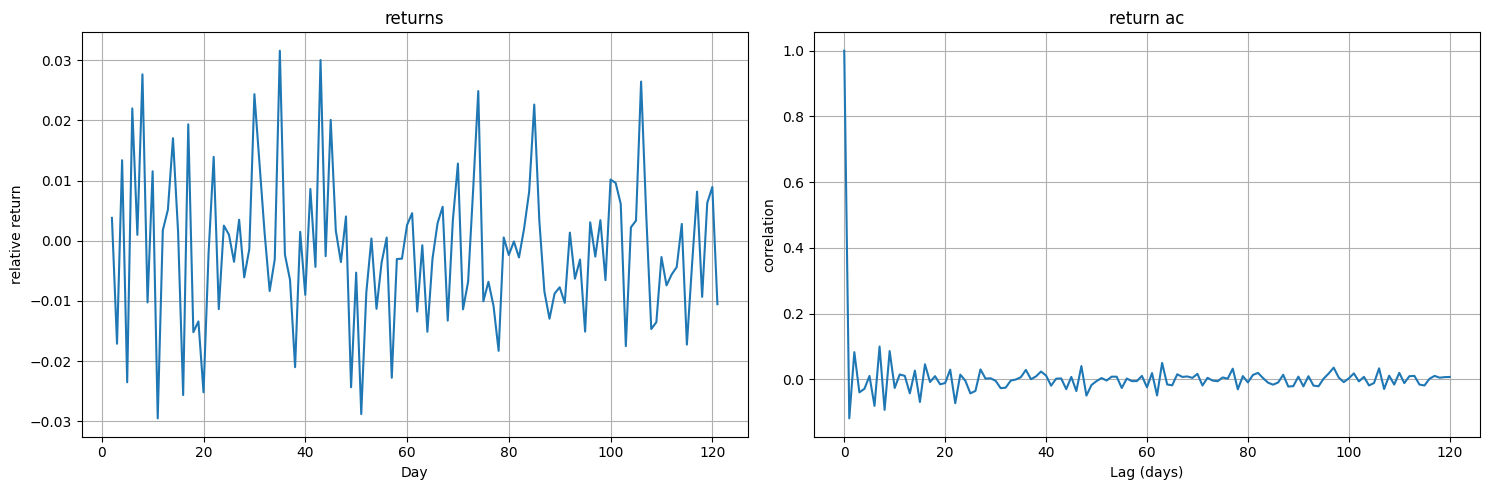

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
#axs[0].plot(returns[:50])
axs[0].plot(returns[1:121])
axs[0].set_title('returns')
axs[1].plot(acf(returns, nlags = 120))
axs[1].set_title('return ac')

for ax in axs: ax.grid(True)
plt.setp(axs[0], xlabel='Day')
plt.setp(axs[1], xlabel='Lag (days)')
plt.setp(axs[0], ylabel='relative return')
plt.setp(axs[1], ylabel='autocorrelation')
axs[1].set_ylabel('correlation')
plt.tight_layout()

## Step 1: Log returns r_{1:T}

Calculate the log return series r_t = $\log\biggl(\frac{s_t}{s_{t-1}}\biggr) \text { for all } t \in \{1, ..., T\}$.

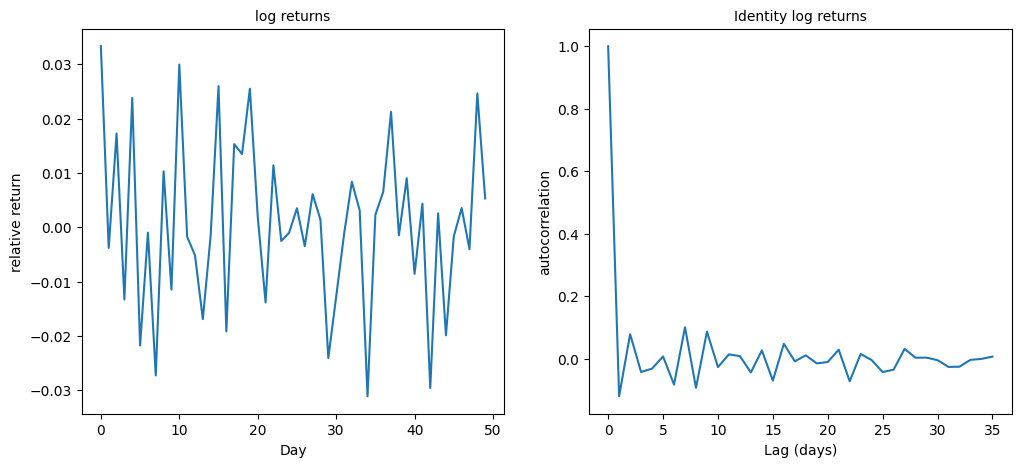

In [10]:
log_returns = np.log(df/df.shift(1))[1:].to_numpy()
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

axs[0].plot(log_returns[0:50],linewidth = 1.5)
axs[0].set_title('log returns', size = 10)
axs[1].plot(acf(log_returns, 50), linewidth = 1.5)
axs[1].set_title('Identity log returns', size = 10)

axs[0].set_xlabel('Day', size = 10)
axs[1].set_xlabel('Lag (days)', size = 10)
axs[0].set_ylabel('relative return', size = 10)
axs[1].set_ylabel('autocorrelation', size = 10)
axs[0].tick_params(axis='both', which='both', labelsize=10)
axs[1].tick_params(axis='both', which='both', labelsize=10)


In [36]:
def leverage_effect(arr, k):
  le = []
  arr2 = arr**2
  for i in range(1,k):
    corr = np.corrcoef(arr2[i:].flatten(),arr[:-i].flatten())[0][1]
    le.append(corr)
  return np.array(le)

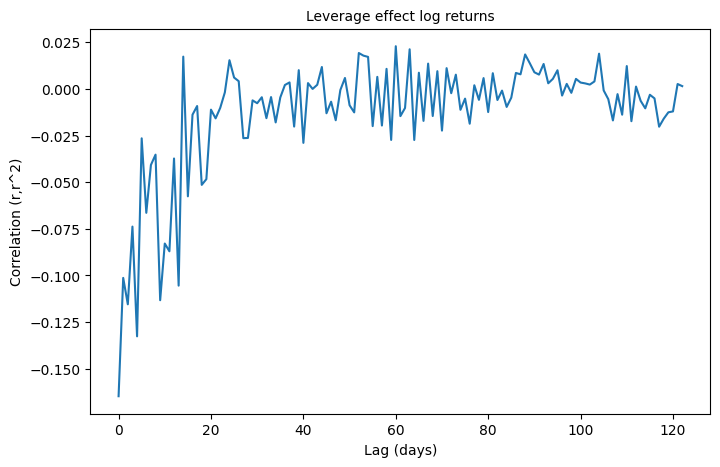

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(leverage_effect(log_returns, 125), linewidth = 1.5)
ax.set_title('Leverage effect log returns', size = 10)
ax.set_xlabel('Lag (days)', size = 10)
ax.set_ylabel('Correlation (r,r^2)', size = 10)
ax.tick_params(axis='both', which='both', labelsize=10)

## Step 2 and 4: Normalization

For numerical reasons, we normalize the data in order to obtain a series with zero mean and unit variance, which is thoroughly derived in LeCun et al. (1998)

In [13]:
from sklearn.preprocessing import StandardScaler
from gaussianize import *

standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize(max_iter=1000)
log_returns = log_returns.reshape(-1,1)
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))

/content/gaussianize.py:180: UserWarning: Warning: No convergence after 1000 iterations. Increase max_iter.
  warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)


## Step 5: Rolling Window

In [14]:
def rolling_window(x, k, sparse=True):
    """compute rolling windows from timeseries

    Args:
        x ([2d array]): x contains the time series in the shape (timestep, sample).
        k ([int]): window length.
        sparse (bool): Cut off the final windows containing NA. Defaults to True.

    Returns:
        [3d array]: array of rolling windows in the shape (window, timestep, sample).
    """
    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]

    if not sparse:
        return out

    return out[:, :-(k-1)]

In [15]:
log_returns_rolled = rolling_window(log_returns_preprocessed, 127)

(-4.0, 4.0)

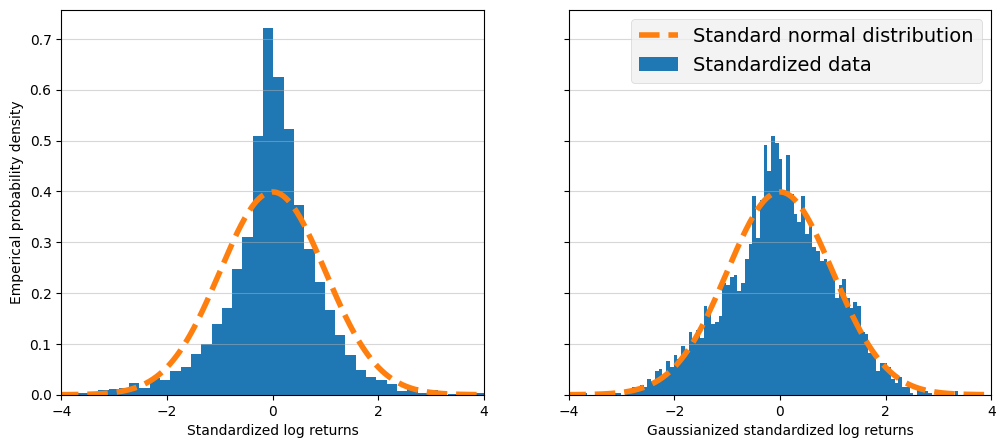

In [16]:
from scipy.stats import norm

fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True, sharex=True)
# Log returns before and after the lambert W inverse transform respectively (both standardized).
plt.style.use('fivethirtyeight')

ax[0].hist(standardScaler1.transform(log_returns), bins=100, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[1].hist(log_returns_preprocessed, bins=100, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range), linestyle='dashed')

# add a grid to compare easily
ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5);

ax[1].legend(['Standard normal distribution', 'Standardized data'])
ax[0].set_ylabel('Emperical probability density')
ax[0].set_xlabel('Standardized log returns')
ax[1].set_xlabel('Gaussianized standardized log returns')

ax[0].set_xlim(-4, 4)


## Torch CNN - GANs

In [17]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

In [18]:
"""
  The activations of the temporal convolutions are "chomped", or sliced at the end by the number of zero-padding that was added.
  This ensures that the size of the input and the hidden layers match.
"""

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

In [19]:
class TemporalBlock(nn.Module):
    """Creates a temporal block.
    Args:
        n_inputs (int): number of inputs.
        n_outputs (int): size of fully connected layers.
        kernel_size (int): kernel size along temporal axis of convolution layers within the temporal block.
        dilation (int): dilation of convolution layers along temporal axis within the temporal block.
        padding (int): padding
        dropout (float): dropout rate
    Returns:
        tuple of output layers
    """
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, batch_norm = False, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.PReLU()
        self.dropout2 = nn.Dropout(dropout)

        if padding == 0:
            self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        else:
            self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)

        if batch_norm:
          self.net.add_module("batch_normalization", nn.BatchNorm1d(num_features=n_outputs, momentum=.9, eps=1e-5))

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.PReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.5)
        self.conv2.weight.data.normal_(0, 0.5)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.5)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out, self.relu(out + res)


In [20]:
class Generator(nn.Module):
    """Generator: 3 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """
    def __init__(self):
        super(Generator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(3, 80, kernel_size=1, stride=1, dilation=1, padding=0, batch_norm = True),
                                 *[TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i,batch_norm = True) for i in [1, 2, 4, 8, 16, 32]]])
        self.last = nn.Conv1d(80, 1, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x

In [21]:
num_epochs = 100
nz = 3
batch_size = 64
seq_len = 127
clip= 0.01
lr_g = 3e-4
lr_d =1e-4

if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"

device = torch.device(dev)

In [22]:
class Loader32(Dataset):

    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)

    def __len__(self):
        return max(len(self.data)-self.length, 0)

In [23]:
class Discriminator(nn.Module):
    """Discrimnator: 1 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """
    def __init__(self, seq_len, conv_dropout=0.05):
        super(Discriminator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(1, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8, 16, 32]]])
        self.last = nn.Conv1d(80, 1, kernel_size=1, dilation=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        # print(len(x))
        return self.sigmoid(x).squeeze()

In [24]:
generator_path = f'/content/temporalCN/'
if not os.path.exists(generator_path):
    os.makedirs(generator_path)

In [25]:
import torch.optim as optim

generator = Generator().to(device)
criterion = nn.BCELoss()

train = True

if train:
    discriminator = Discriminator(seq_len).to(device)
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr_g, betas = [0,0.9])
    gen_optimizer = optim.Adam(generator.parameters(), lr=lr_d, betas = [0,0.9])

    dataset = Loader32(log_returns_preprocessed, 127)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    dataset = Loader32(log_returns_preprocessed, 1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    for epoch in range(num_epochs):
        for idx, data in enumerate(dataloader):

            discriminator.zero_grad()
            real = data.to(device)
            real_output = discriminator(real)
            batch_size, seq_len = real.size(0), real.size(1)

            noise = torch.randn(batch_size, nz, seq_len, device=device)
            fake = discriminator(generator(noise))
            one = torch.ones(real.shape[0]).to(device)
            zero = torch.ones(fake.shape[0]).to(device)
            d_x_loss = criterion(real_output, one)
            d_z_loss = criterion(fake, zero)
            disc_loss =  d_x_loss + d_z_loss

            disc_loss.backward()
            disc_optimizer.step()

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)

            noise = torch.randn(batch_size, nz, seq_len, device=device)
            fake = discriminator(generator(noise))
            gen_loss = -1 * criterion(fake, zero)

            generator.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

        if epoch % 10 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, num_epochs, epoch, disc_loss.item(), gen_loss.item()))
    # Save
    torch.save(generator, f'{generator_path}trained_generator_{file_name}_epoch_{epoch}.pth')

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Epoch: 0/100, Step: 0, D Loss: 1.3444278240203857, G Loss: -0.6718584299087524
Epoch: 10/100, Step: 10, D Loss: 1.3281688690185547, G Loss: -0.6641103029251099
Epoch: 20/100, Step: 20, D Loss: 1.3281183242797852, G Loss: -0.6642640829086304
Epoch: 30/100, Step: 30, D Loss: 1.3281939029693604, G Loss: -0.6641918420791626
Epoch: 40/100, Step: 40, D Loss: 1.3282921314239502, G Loss: -0.6642992496490479
Epoch: 50/100, Step: 50, D Loss: 1.328282117843628, G Loss: -0.6642661690711975
Epoch: 60/100, Step: 60, D Loss: 1.328382968902588, G Loss: -0.6642903089523315
Epoch: 70/100, Step: 70, D Loss: 1.3282109498977661, G Loss: -0.664164662361145
Epoch: 80/100, Step: 80, D Loss: 1.3284399509429932, G Loss: -0.664188027381897
Epoch: 90/100, Step: 90, D Loss: 1.3283747434616089, G Loss: -0.6641538143157959


In [26]:
generator.eval()
noise = torch.randn(100,3,120).to(device)
y = generator(noise).cpu().detach().squeeze();
y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()


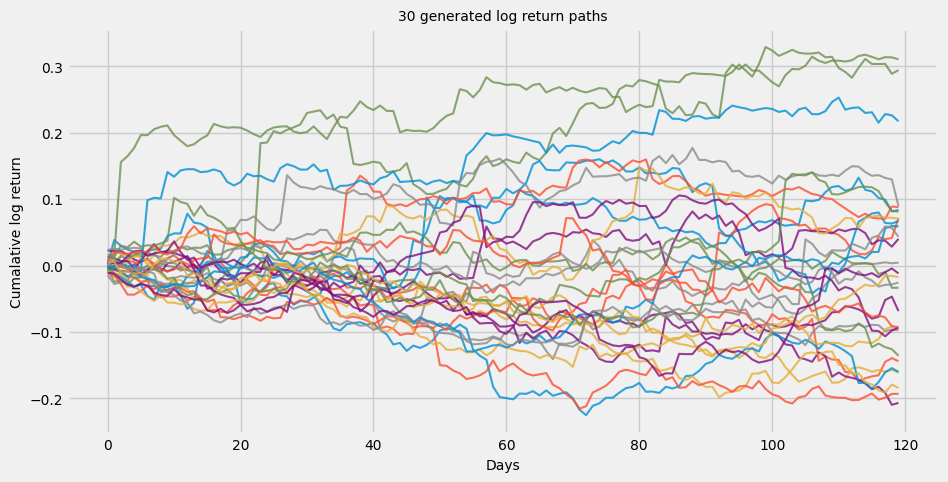

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.cumsum(y[:30], axis=1).T, alpha = 0.8, linewidth=1.5)
ax.set_title('30 generated log return paths', size = 10)
ax.set_xlabel('Days', size = 10)
ax.set_ylabel('Cumalative log return', size = 10);
ax.tick_params(axis='both', which='both', labelsize=10)
fig.savefig("paths.png")

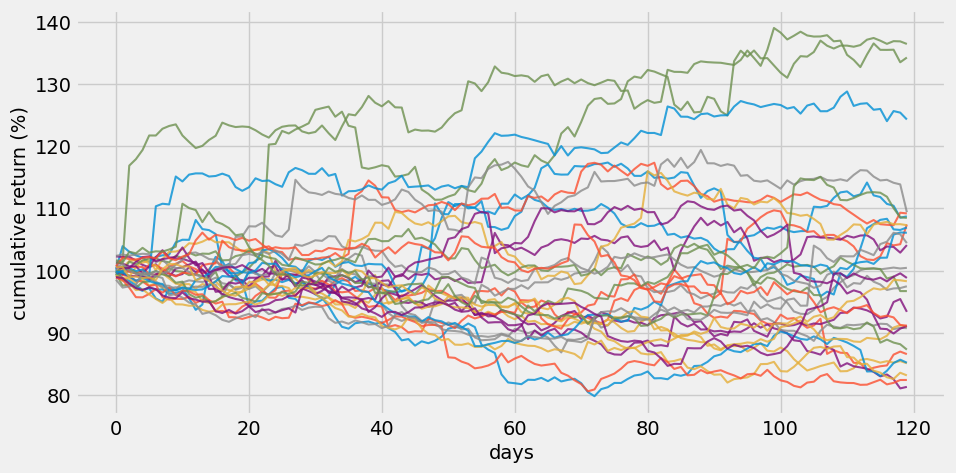

In [44]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(np.exp(y.T[:,:30]).cumprod(axis=0)*100, alpha=0.8, linewidth = 1.5)
ax.set_xlabel('days', size=14)
ax.set_ylabel('cumulative return (%)', size=14)

plt.savefig('sp500_paths.png', dpi=300)

### Evaluating the generated data

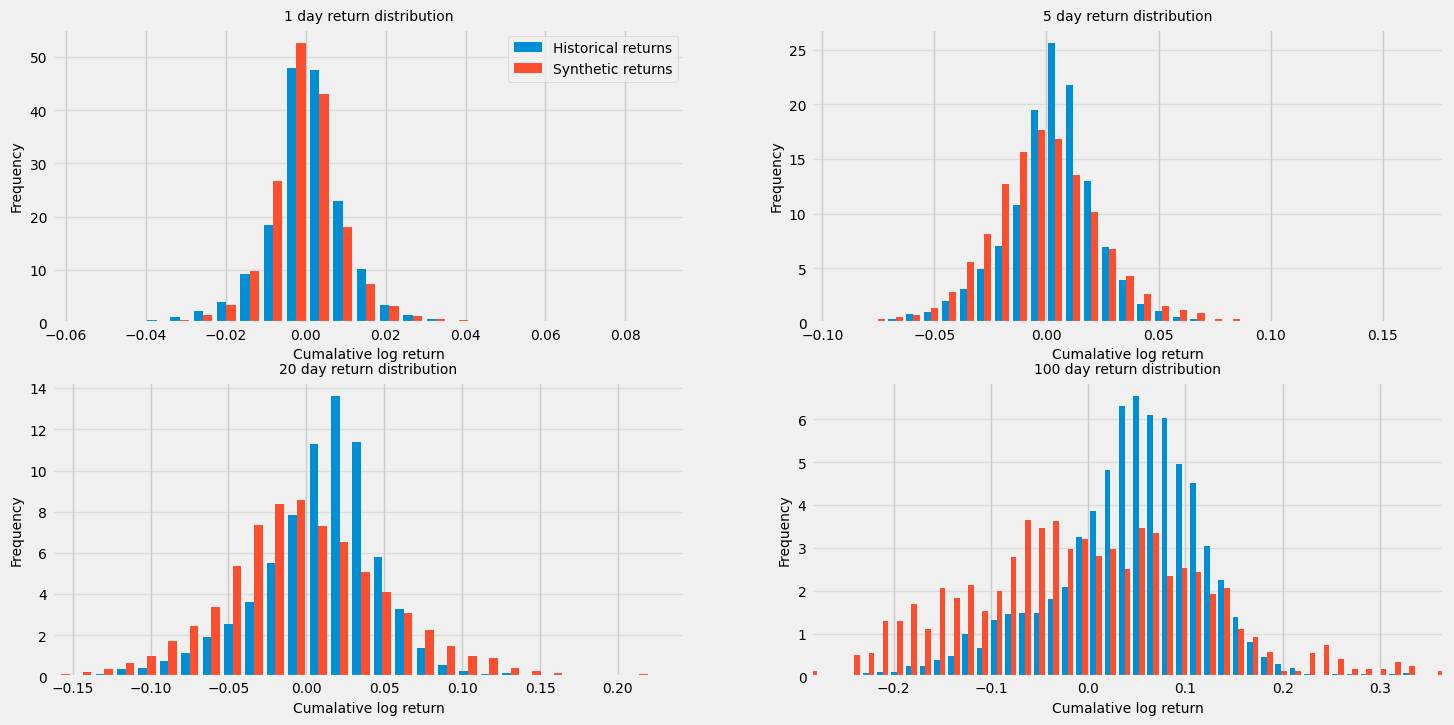

In [29]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=10)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return', size = 10)
    axs[row,col].set_ylabel('Frequency', size = 10)
    axs[row,col].tick_params(axis='both', which='both', labelsize=10)

axs[0,0].legend(['Historical returns', 'Synthetic returns'], fontsize=10)
fig.savefig("dist.png")

In [30]:
from scipy.stats import wasserstein_distance, norm, kurtosis, skew, skewtest, kurtosistest
from google.colab import files

In [31]:
windows = pd.Series([1, 5, 20, 100], name='window size')
stats_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).squeeze()
    stats_array[i, 0] = skew(real_dist)
    stats_array[i, 1] = skewtest(real_dist).pvalue
    stats_array[i, 2] = kurtosis(real_dist)
    stats_array[i, 3] = kurtosistest(real_dist).pvalue

stats_df = pd.DataFrame(np.round(stats_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value'], index=windows)

with open("stats_real.tex", "w") as fh:
    fh.write(stats_df.to_latex())
files.download("stats_real.tex")

stats_df

<ipython-input-31-cb2003804038>:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  fh.write(stats_df.to_latex())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,skewness,skewness p-value,kurtosis,kurtosis p-value
window size,,,,
1,-0.685,0.0,12.341,0.0
5,-0.969,0.0,6.617,0.0
20,-1.651,0.0,9.896,0.0
100,-0.454,0.0,1.165,0.0


In [32]:
windows = pd.Series([1, 5, 20, 100], name='window size')
stats_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    fake_di = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    stats_array[i, 0] = skew(fake_di)
    stats_array[i, 1] = skewtest(fake_di).pvalue
    stats_array[i, 2] = kurtosis(fake_di)
    stats_array[i, 3] = kurtosistest(fake_di).pvalue

stats_df = pd.DataFrame(np.round(stats_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value'], index=windows)

with open("stats_fake.tex", "w") as fh:
    fh.write(stats_df.to_latex())
files.download("stats_fake.tex")

stats_df

<ipython-input-32-35b093b95471>:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  fh.write(stats_df.to_latex())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,skewness,skewness p-value,kurtosis,kurtosis p-value
window size,,,,
1,1.576,0.0,23.940,0.000
5,0.766,0.0,4.627,0.000
20,0.462,0.0,1.372,0.000
100,0.253,0.0,-0.069,0.567


In [33]:
windows = pd.Series([1, 5, 20, 100], name='window size')
EMDscores = np.zeros(len(windows))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()

    EMDscores[i] = wasserstein_distance(real_dist, fake_dist)

df_EMD = pd.DataFrame({'Earth Mover Distance' : EMDscores}, index=windows)
with open("EMD_Scores.tex", "w") as fh:
    fh.write(df_EMD.to_latex())
files.download("EMD_Scores.tex")
df_EMD

<ipython-input-33-b50249b128d8>:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  fh.write(df_EMD.to_latex())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Earth Mover Distance
window size,
1,0.001444
5,0.006078
20,0.018610
100,0.057291


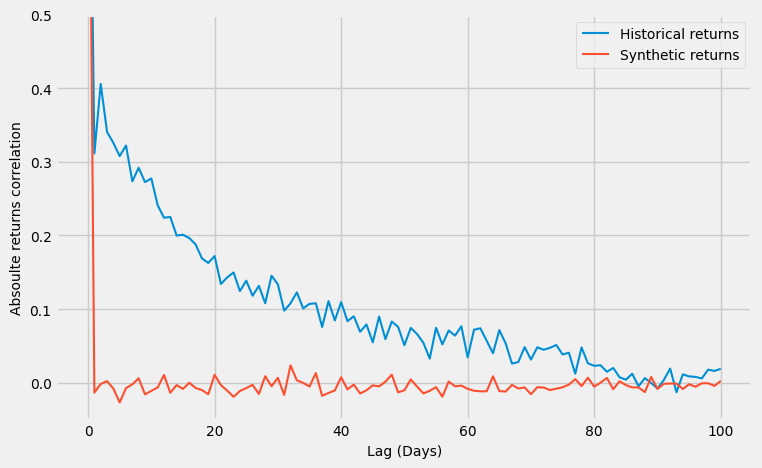

In [34]:
fig, axs = plt.subplots(figsize=(8, 5))
axs.plot(acf(abs(log_returns), nlags = 100), linewidth = 1.5)
synthetic_acf = np.array([acf(abs(x), nlags = 100) for x in y]).mean(axis = 0)
axs.plot(synthetic_acf, linewidth = 1.5)
axs.set_ylim(-0.05, 0.5)
axs.set_ylabel('Absoulte returns correlation', size = 10)
axs.set_xlabel('Lag (Days)', size = 10)
axs.tick_params(axis='both', which='both', labelsize=10)
axs.legend(['Historical returns', 'Synthetic returns'], fontsize=10)
fig.savefig("acf.png")

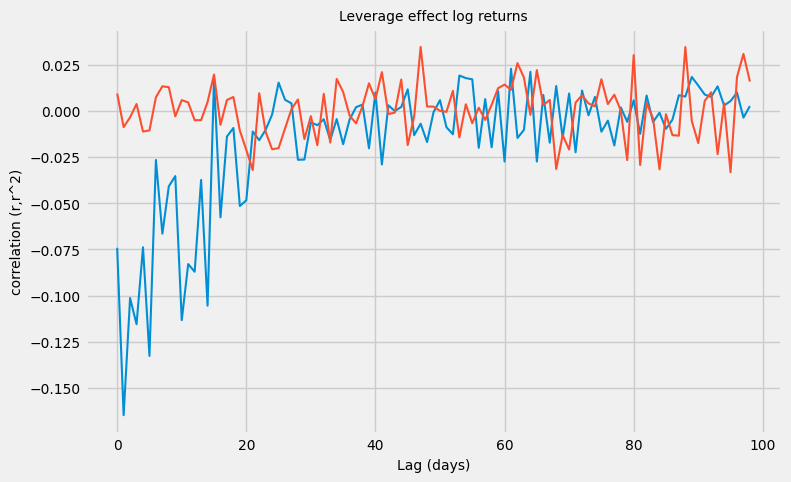

In [37]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(leverage_effect(log_returns, 100), linewidth = 1.5)
synthetic_leverage = np.array([leverage_effect(x, 100) for x in y]).mean(axis = 0)
ax.plot(synthetic_leverage, linewidth = 1.5)
ax.set_title('Leverage effect log returns', size = 10)
ax.set_xlabel('Lag (days)', size = 10)
ax.set_ylabel('autocorrelation', size = 10)
ax.set_ylabel('correlation (r,r^2)', size = 10);
ax.tick_params(axis='both', which='both', labelsize=10)
axs.legend(['Historical returns', 'Synthetic returns'], fontsize=10)
fig.savefig("le.png")